<a href="https://colab.research.google.com/github/tfreyd/TensorflowCoursera/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_2_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.7.0'

In [57]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)

In [58]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 61.5MB/s]


In [59]:
import csv
time_step=[]
sunspots=[]

with open('/content/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

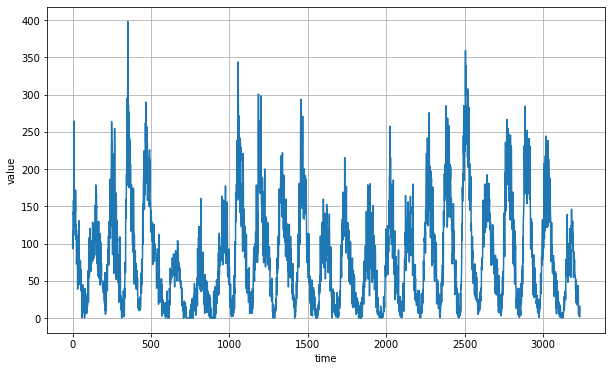

In [60]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

In [61]:
split_time = 3000 
time_train = time[:split_time]
x_train= series[:split_time]
time_valid= time[split_time:]
x_valid= series[split_time:]

window_size= 30
batch_size = 32
shuffle_buffer_size = 1000 
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds= tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size +1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1],w[-1]))

  return ds.batch(batch_size).prefetch(1)

In [62]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size=64
batch_size=256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [64]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',activation='relu',
                           input_shape=[None,1]),
    
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x *400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)

model.compile(loss='Huber',
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

12/12 [==============================] - 1s 32ms/step - loss: 55.7768 - mae: 56.2751 - lr: 5.0119e-04
Epoch 96/100
12/12 [==============================] - 1s 32ms/step - loss: 47.1010 - mae: 47.5987 - lr: 5.6234e-04
Epoch 97/100
12/12 [==============================] - 1s 32ms/step - loss: 50.8156 - mae: 51.3140 - lr: 6.3096e-04
Epoch 98/100
12/12 [==============================] - 1s 33ms/step - loss: 63.5175 - mae: 64.0162 - lr: 7.0795e-04
Epoch 99/100
12/12 [==============================] - 1s 33ms/step - loss: 57.4058 - mae: 57.9036 - lr: 7.9433e-04
Epoch 100/100
12/12 [==============================] - 1s 32ms/step - loss: 56.8489 - mae: 57.3468 - lr: 8.9125e-04


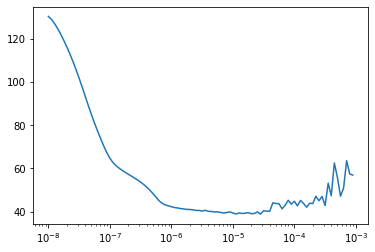

In [65]:
plt.semilogx(history.history['lr'],history.history['loss'])

In [66]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',activation='relu',
                           input_shape=[None,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x *400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)

model.compile(loss='Huber',
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=500)

Epoch 1/500
12/12 [==============================] - 6s 33ms/step - loss: 38.8149 - mae: 39.3111
Epoch 2/500
12/12 [==============================] - 1s 36ms/step - loss: 29.8351 - mae: 30.3313
Epoch 3/500
12/12 [==============================] - 1s 37ms/step - loss: 25.6334 - mae: 26.1281
Epoch 4/500
12/12 [==============================] - 1s 36ms/step - loss: 23.6048 - mae: 24.0992
Epoch 5/500
12/12 [==============================] - 1s 36ms/step - loss: 22.0881 - mae: 22.5828
Epoch 6/500
12/12 [==============================] - 1s 35ms/step - loss: 21.1926 - mae: 21.6850
Epoch 7/500
12/12 [==============================] - 1s 37ms/step - loss: 21.3417 - mae: 21.8362
Epoch 8/500
12/12 [==============================] - 1s 37ms/step - loss: 20.9399 - mae: 21.4342
Epoch 9/500
12/12 [==============================] - 1s 36ms/step - loss: 20.4239 - mae: 20.9185
Epoch 10/500
12/12 [==============================] - 1s 37ms/step - loss: 19.2976 - mae: 19.7902
Epoch 11/500
12/12 [=========

In [67]:
#caling the forecast function defined at the beginnning

rnn_forecast = model_forecast(model, series[..., np.newaxis],window_size)

In [68]:
rnn_forecast.shape

(3172, 1)

In [69]:
rnn_forecast = rnn_forecast[split_time - window_size:-1,0]

In [70]:
rnn_forecast.shape

(235,)

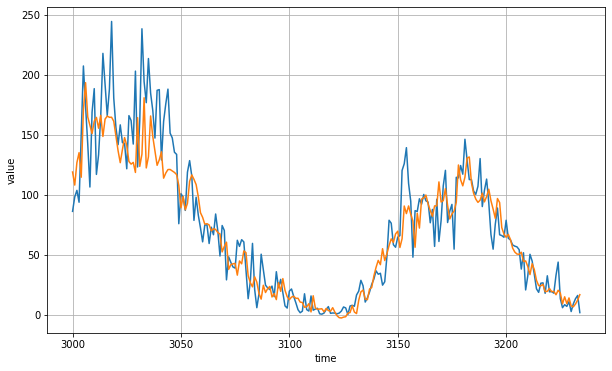

In [71]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [72]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.511277

<Figure size 432x288 with 0 Axes>

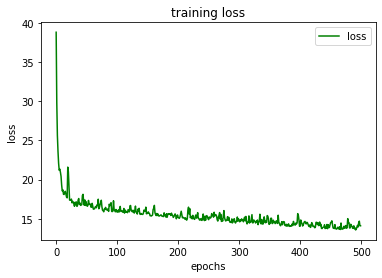

<Figure size 432x288 with 0 Axes>

In [73]:
#plotting 

loss = history.history['loss']
epochs = range(len(loss))


plt.plot(epochs, loss, 'g',label='loss')
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()



<Figure size 432x288 with 0 Axes>

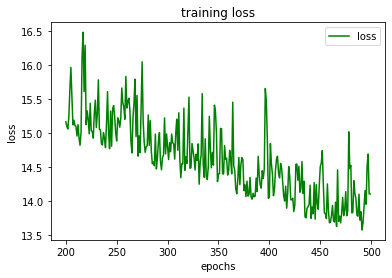

<Figure size 432x288 with 0 Axes>

In [75]:
zoom_loss = loss[200:]
zoom_epochs= epochs[200:]

plt.plot(zoom_epochs, zoom_loss, 'g',label='loss')
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()